## FX Model Computer Assigment 
### Jiahao Zhu, N14368952, jz3511

In [34]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

## Calibration

In [2]:
# foreign currency interest rate,USD
r_f = 0.022
# domestic currency interest rate,BRL
r_d = 0.065
# spot rate
spot = 3.724

# discount factor in foreign currency, as a funtion of time
P = lambda T:np.exp(-r_f*T)
# forward rate, as a function of time
F = lambda T:spot*np.exp((r_d - r_f)*T)

# fomula for call delta, as a function of K
def callK(K):
    return P(T) * (K/F(T))*norm.cdf((np.log(spot/K)+(r_d-r_f -0.5*v*v)*T)/(v*np.sqrt(T))) -0.25

# formula for put delta, as a function of K

def putK(K):
    return -P(T) * (K/F(T))*norm.cdf(-(np.log(spot/K)+(r_d-r_f -0.5*v*v)*T)/(v*np.sqrt(T))) + 0.25


# z used in Hagan
def findz(K,alpha,beta,nu):
    return (nu/alpha)*(F(T)*K)**((1-beta)/2)*np.log(F(T)/K)

# x used in Hagan
def x(z,rho):
    return np.log((np.sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho))
    

# volatility function using SABR Hagan approximation, as a function of K,alpha,beta,rho,nu
def vol(K,alpha,beta,rho,nu):
    z = findz(K,alpha,beta,nu)
    return (alpha/( (F(T)*K)**((1-beta)/2) * (1+ (1-beta)**2*(np.log(F(T)/K))**2/24 + (1-beta)**4*(np.log(F(T)/K))**4/1920)))\
*(z/x(z,rho))\
*(1+(((1-beta)**2*alpha**2)/(24*(F(T)*K)**(1-beta))+(0.25*rho*beta*nu*alpha)/((F(T)*K)**((1-beta)/2))+((2-3*rho**2)*nu**2)/(24))*T)
        
# function to use vol to find parameters
def findP(Param):
    alpha,rho,nu = Param[0],Param[1],Param[2]
    return[vol(K_ATM,alpha,beta,rho,nu)-atm,\
          vol(K_RR_call,alpha,beta,rho,nu)-vol(K_RR_put,alpha,beta,rho,nu)-rr,\
          (vol(K_BF_call,alpha,beta,rho,nu)+vol(K_BF_put,alpha,beta,rho,nu))/2 - vol(K_ATM,alpha,beta,rho,nu) - bf]
                                            
                                            
                                            



In [24]:
# Market Quotes, subject to change based on the table given
T = 1
atm = 0.1394
rr = 0.029
bf = 0.0055

# solve atm K
K_ATM = np.exp(-0.5*atm*atm*T)*F(T)
print("K_ATM is {}".format(K_ATM))

# solve K_RRcall
v = atm + bf + rr/2
K_RR_call = fsolve(callK,[spot])[0]
print("K_RRcall is {}".format(K_RR_call))

# solve K_RRput
v = atm + bf -rr/2
K_RR_put = fsolve(putK,[spot])[0]
print("K_RRput is {}".format(K_RR_put))

# solve for K_BFcall
v = atm + bf
K_BF_call = fsolve(callK,[spot])[0]
print("K_BFcall is {}".format(K_BF_call))

# solve for K_BFput
v = atm + bf
K_BF_put = fsolve(putK,[spot])[0]
print("K_BFput is {}".format(K_BF_put))


K_ATM is 3.850034769950248
K_RRcall is 4.318133722512803
K_RRput is 3.5702190461507897
K_BFcall is 4.277073911318569
K_BFput is 3.5368504017952054


In [25]:
# solve for parameters

# determine beta
beta = 0.5

# find parameters with bound
params = least_squares(findP,[0.6,0,5],bounds = ([1e-5,-1+1e-5,0],[np.inf,1-1e-5,np.inf]))

alpha,rho,nu = params['x'][0],params['x'][1],params['x'][2]

print("alpha is {}, rho is {}, and nu is {}".format(alpha,rho,nu))


alpha is 0.2684396892778542, rho is 0.5027944050918539, and nu is 0.7391841142834429


In [26]:
# Find implied Vol

# vol_ATM
vol_ATM = vol(K_ATM,alpha,beta,rho,nu)
print("vol_ATM is {}".format(vol_ATM))

# vol_RRCall
vol_RRCall = vol(K_RR_call,alpha,beta,rho,nu)
print("vol_RRCall is {}".format(vol_RRCall))

# vol_RRPut
vol_RRPut = vol(K_RR_put,alpha,beta,rho,nu)
print("vol_RRPut is {}".format(vol_RRPut))

# vol_BFCall
vol_BFCall = vol(K_BF_call,alpha,beta,rho,nu)
print("vol_BFCall is {}".format(vol_BFCall))

# vol_BFPut
vol_BFPut = vol(K_BF_put,alpha,beta,rho,nu)
print("vol_BFPut is {}".format(vol_BFPut))


vol_ATM is 0.1394000007569008
vol_RRCall is 0.16059262001160007
vol_RRPut is 0.13159262341724406
vol_BFCall is 0.15862685061882756
vol_BFPut is 0.13117315819083442


## volatility smile

In [29]:
# fomula for call delta, as a function of K, to solve delta = -.1 case
def callK_1(K):
    return P(T) * (K/F(T))*norm.cdf((np.log(spot/K)+(r_d-r_f -0.5*v*v)*T)/(v*np.sqrt(T))) - 0.1

# formula for put delta, as a function of K, to solve delta = 0.1 case

def putK_1(K):
    return -P(T) * (K/F(T))*norm.cdf(-(np.log(spot/K)+(r_d-r_f -0.5*v*v)*T)/(v*np.sqrt(T))) + 0.1

In [31]:
strike_call = fsolve(callK_1,[spot])[0]
print("The strike for 0.1 delta call is {}".format(strike_call))

strike_put = fsolve(putK_1,[spot])[0]
print("The strike for -0.1 delta put is {}".format(strike_put))

The strike for 0.1 delta call is 4.694823173449
The strike for -0.1 delta put is 3.250090788071198


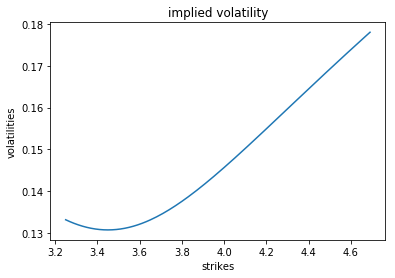

In [36]:
# get volalitity smile for this range of strikes

# strikes
strikes = list(np.arange(strike_put,strike_call,0.01))
# implied vols
vols = [vol(K,alpha,beta,rho,nu) for K in strikes]

# plot
plt.plot(strikes,vols)
plt.title("implied volatility")
plt.xlabel("strikes")
plt.ylabel("volatilities")
plt.show()
